In [1]:
import os
import sys

sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join

import energyflow as ef
import h5py
import hydra
import numpy as np
import pytorch_lightning as pl
import torch
from omegaconf import OmegaConf
from sklearn.neighbors import KernelDensity
import pandas as pd

2023-09-09 22:46:22.188624: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 22:46:23.013375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# plots and metrics
import matplotlib.pyplot as plt

from src.data.components import (
    calculate_all_wasserstein_metrics,
    inverse_normalize_tensor,
    normalize_tensor,
)
from src.utils.data_generation import generate_data
from src.utils.plotting import apply_mpl_styles, plot_data, prepare_data_for_plotting

apply_mpl_styles()

In [4]:
from jetnet.evaluation import w1efp, w1m, w1p
from src.utils.jet_substructure import dump_hlvs
from src.data.components.metrics import wasserstein_distance_batched
from src.utils.plotting import (
    plot_substructure,
    plot_full_substructure,
)

In [5]:
# set env variable DATA_DIR again because of hydra
from dotenv import load_dotenv

load_dotenv()
os.environ["DATA_DIR"] = os.environ.get("DATA_DIR")

In [6]:
data_folder = os.environ.get("DATA_DIR")

## load data

In [7]:
# Load vinicius data
path_v = f"{data_folder}/lhco/generated/FPCD_LHCO_SR.h5"
with h5py.File(path_v, "r") as f:
    print(f.keys())
    jet_features_v = f["jet_features"][:]
    particle_data_v = f["particle_features"][:]
    mjj_v = f["mjj"][:]
print(jet_features_v.shape)
print(particle_data_v.shape)
print(mjj_v.shape)

<KeysViewHDF5 ['jet_features', 'mjj', 'particle_features']>
(200000, 2, 5)
(200000, 2, 279, 3)
(200000,)


In [8]:
# Load idealized data
path_id = f"{data_folder}/lhco/generated/idealized_LHCO.h5"
with h5py.File(path_id, "r") as f:
    print(f.keys())
    jet_features_id = f["jet_features"][:]
    particle_data_id = f["particle_features"][:]
    mjj_id = f["mjj"][:]
print(jet_features_id.shape)
print(particle_data_id.shape)
print(mjj_id.shape)

<KeysViewHDF5 ['jet_features', 'mjj', 'particle_features']>
(121351, 2, 5)
(121351, 2, 279, 3)
(121351,)


In [9]:
# Load ced data
#path_ced = f"{data_folder}/lhco/generated/FM_LHCO_SR.h5"
#path_ced = f"{data_folder}/lhco/generated/lhco_both_jets-midpoint-250.h5"
#path_ced = f"{data_folder}/lhco/generated/latent64-midpoint-200.h5"
#path_ced = f"{data_folder}/lhco/generated/lhco-xy-midpoint-300.h5"
path_ced = f"{data_folder}/lhco/generated/lhco-xy-256-logpt_sr-midpoint-500.h5"
#path_ced = f"{data_folder}/lhco/generated/FPCD_LHCO_SR_2.h5"


with h5py.File(path_ced, "r") as f:
    print(f.keys())
    jet_features_ced = f["jet_features"][:]
    particle_data_ced = f["particle_features"][:]
    mjj_ced = f["mjj"][:]
    raw_ced = f["data_raw"][:]
print(jet_features_ced.shape)
print(particle_data_ced.shape)
#print(mjj_ced.shape)

<KeysViewHDF5 ['data_raw', 'jet_features', 'mjj', 'particle_features', 'particle_features_nonrel']>
(121351, 2, 5)
(121351, 2, 279, 3)


In [10]:
particle_data_v = particle_data_v[:len(particle_data_id)]
jet_features_v = jet_features_v[:len(jet_features_id)]
mjj_v = mjj_v[:len(mjj_id)]

In [11]:
particle_data_ced = particle_data_ced[...,[1,2,0]]
particle_data_id = particle_data_id[...,[1,2,0]]
particle_data_v = particle_data_v[...,[1,2,0]]

## calculate substructure

In [12]:
print(particle_data_ced.shape)
print(particle_data_id.shape)
print(particle_data_v.shape)

(121351, 2, 279, 3)
(121351, 2, 279, 3)
(121351, 2, 279, 3)


In [13]:
print(particle_data_v.reshape(-1, particle_data_v.shape[-2], particle_data_v.shape[-1]).shape)

(242702, 279, 3)


In [14]:
#dump_hlvs(
#    particle_data_v.reshape(-1, particle_data_v.shape[-2], particle_data_v.shape[-1]),
#    "/beegfs/desy/user/ewencedr/data/lhco/substructure/full_v",
#    plot=True,
#)

## Evaluate substructure

In [34]:
# load substructure for id data
data_substructure_id = []
keys = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/full_idealized" + ".h5", "r") as f:
    tau21_id = np.array(f["tau21"])
    tau32_id = np.array(f["tau32"])
    d2_id = np.array(f["d2"])
    for key in f.keys():
        keys.append(key)
        data_substructure_id.append(np.array(f[key]))
keys = np.array(keys)
data_substructure_id = np.array(data_substructure_id)

In [35]:
# load substructure for v data
data_substructure_v = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/full_vinicius" + ".h5", "r") as f:
    tau21_v = np.array(f["tau21"])
    tau32_v = np.array(f["tau32"])
    d2_v = np.array(f["d2"])
    for key in f.keys():
        data_substructure_v.append(np.array(f[key]))
data_substructure_v = np.array(data_substructure_v)

In [36]:
# load substructure for c data
data_substructure_c = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/full_ced" + ".h5", "r") as f:
    tau21_c = np.array(f["tau21"])
    tau32_c = np.array(f["tau32"])
    d2_c = np.array(f["d2"])
    for key in f.keys():
        data_substructure_c.append(np.array(f[key]))
data_substructure_c = np.array(data_substructure_c)

In [37]:
print(data_substructure_id.shape)

(12, 242702)


In [38]:
print(np.count_nonzero(np.isnan(tau21_id)))
print(np.count_nonzero(np.isnan(tau21_v)))
print(np.count_nonzero(np.isnan(tau21_c)))

15
0
9


In [39]:
np.nan_to_num(tau21_id, copy=False)
np.nan_to_num(tau21_c, copy=False)
np.nan_to_num(tau21_v, copy=False)

array([0.67562823, 0.52855357, 0.44387621, ..., 0.49226642, 0.26354404,
       0.51823811])

In [40]:
print(np.count_nonzero(np.isnan(tau21_id)))
print(np.count_nonzero(np.isnan(tau21_v)))
print(np.count_nonzero(np.isnan(tau21_c)))


0
0
0


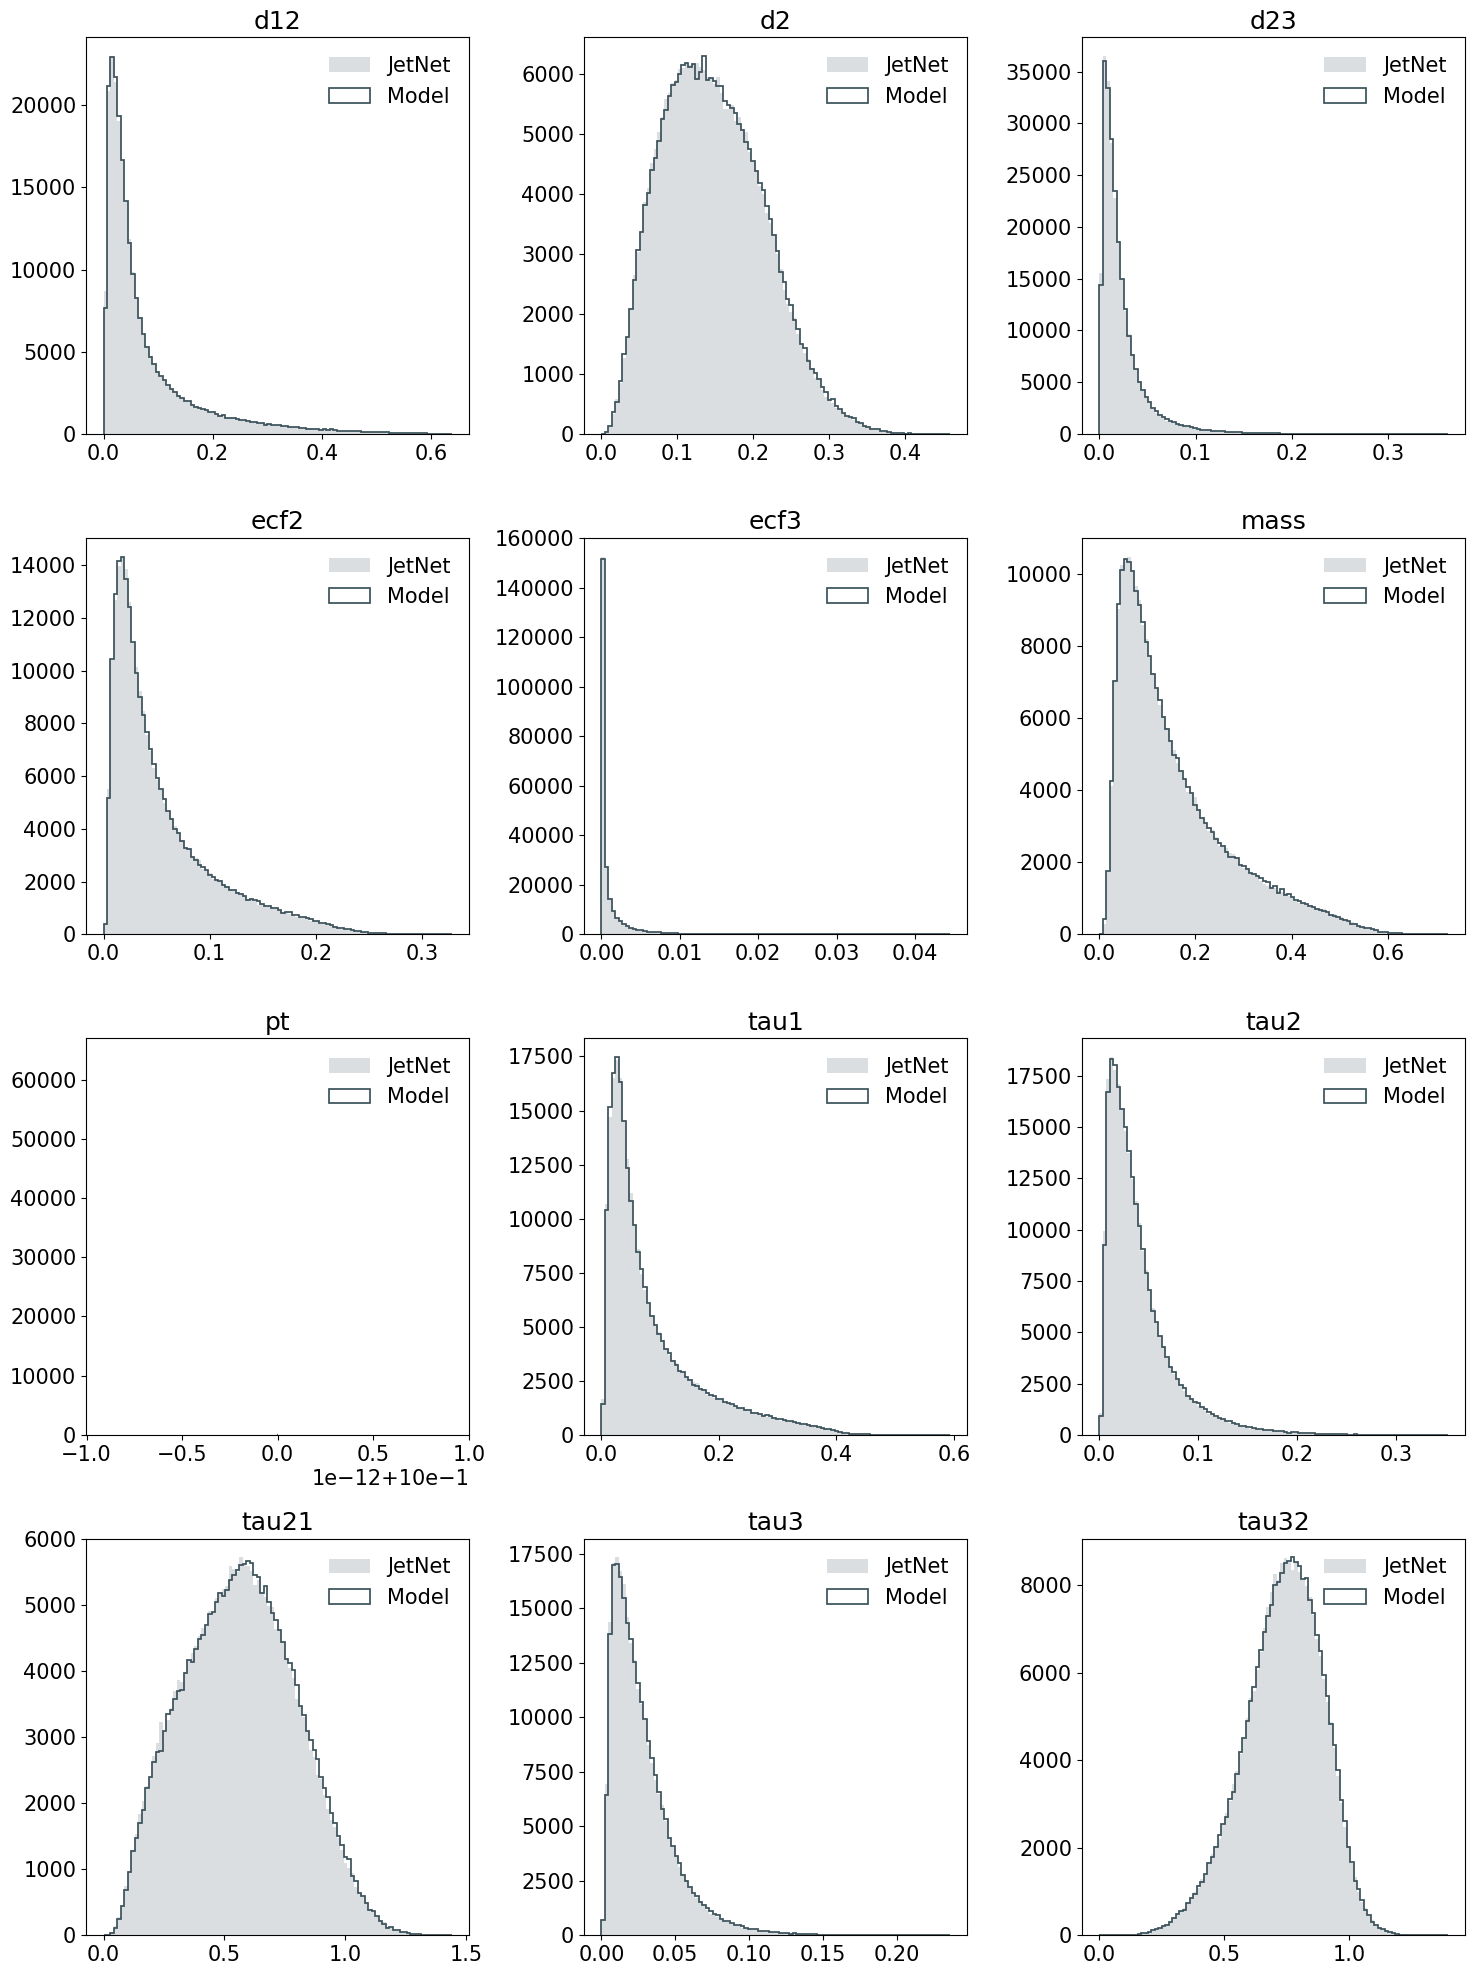

In [41]:
plot_full_substructure(
    data_substructure=data_substructure_v,
    data_substructure_jetnet=data_substructure_id,
    keys=keys,
    save_fig=False,
    save_folder=None,
    save_name=None,
    close_fig=True,
)

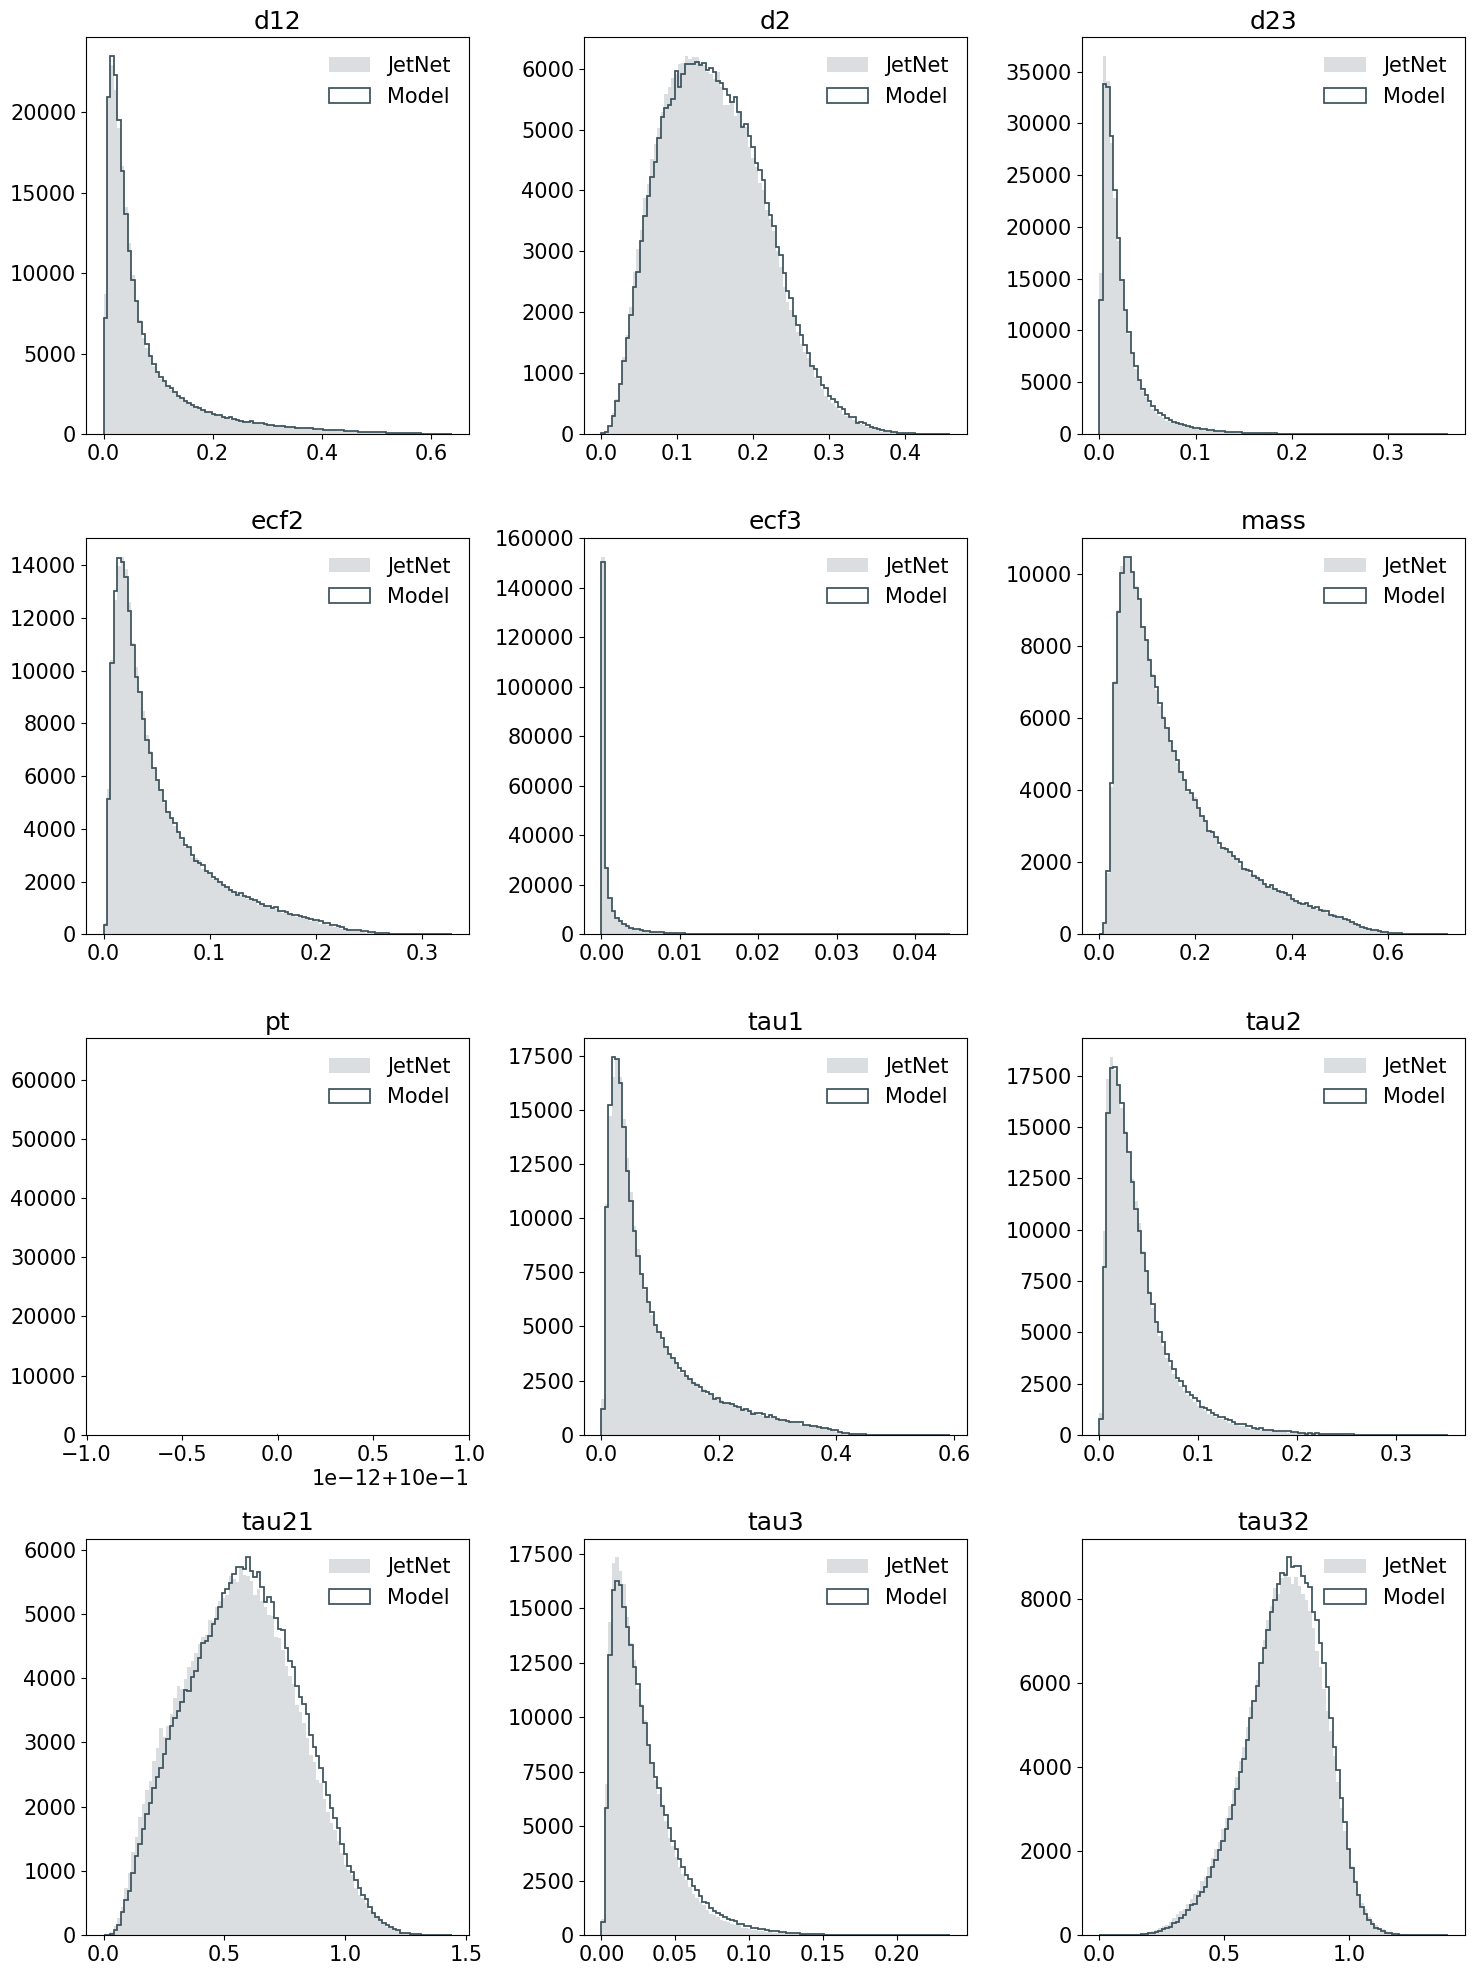

In [42]:
plot_full_substructure(
    data_substructure=data_substructure_c,
    data_substructure_jetnet=data_substructure_id,
    keys=keys,
    save_fig=False,
    save_folder=None,
    save_name=None,
    close_fig=True,
)

## bring data in cathode form

In [43]:
print(tau21_v.shape)
tau_21_v = tau21_v.reshape(-1, 2)
tau_21_id = tau21_id.reshape(-1, 2)
tau_21_c = tau21_c.reshape(-1, 2)
print(tau_21_v.shape)

(242702,)
(121351, 2)


In [44]:
def sort_jet_for_mass(particle_data, jet_features):
    
    jet_mass = jet_features[...,3]
    args = np.argsort(jet_mass, axis=-1)#[...,::-1]
    jet_features = np.take_along_axis(jet_features, args[..., None], axis=1)
    particle_data = np.take_along_axis(particle_data, args[..., None, None], axis=1)
    
    return particle_data, jet_features, args

In [45]:
def get_cathode_data(particle_data: np.array, jet_features: np.array, tau_21: np.array)->np.array:
    # sort jets by pt
    particle_data_sorted, jet_features_sorted, idcs = sort_jet_for_mass(particle_data, jet_features)
    tau_21_sorted = np.take_along_axis(tau_21, idcs, axis=1)
    # get features
    mj1 = jet_features_sorted[:,0,3]
    delta_mj = abs(jet_features_sorted[:,1,3] - jet_features_sorted[:,0,3])
    tau21j1 = tau_21_sorted[:,0]
    tau21j2 = tau_21_sorted[:,1]
    cathode_data = np.stack([mj1, delta_mj, tau21j1, tau21j2], axis=-1)
    return cathode_data

In [46]:
cathode_data_v = get_cathode_data(particle_data_v, jet_features_v, tau_21_v)
cathode_data_id = get_cathode_data(particle_data_id, jet_features_id, tau_21_id)
cathode_data_c = get_cathode_data(particle_data_ced, jet_features_ced, tau_21_c)

## compare to real data

In [47]:
data_path_manuel = "/beegfs/desy/user/sommerhm/clean_notebook_cathode/input_data/"
innerdata_train = np.load(join(data_path_manuel, "innerdata_train.npy"))

In [48]:
data_manuel = innerdata_train[:,1:5]
data_manuel[:,0] = data_manuel[:,0] * 1000
data_manuel[:,1] = data_manuel[:,1] * 1000
print(data_manuel.shape)

(61375, 4)


In [49]:
print(data_manuel.shape)
print(cathode_data_v.shape)
cathode_data_v_plot = cathode_data_v[:len(data_manuel)]
cathode_data_c_plot = cathode_data_c[:len(data_manuel)]
cathode_data_id_plot = cathode_data_id[:len(data_manuel)]

(61375, 4)
(121351, 4)


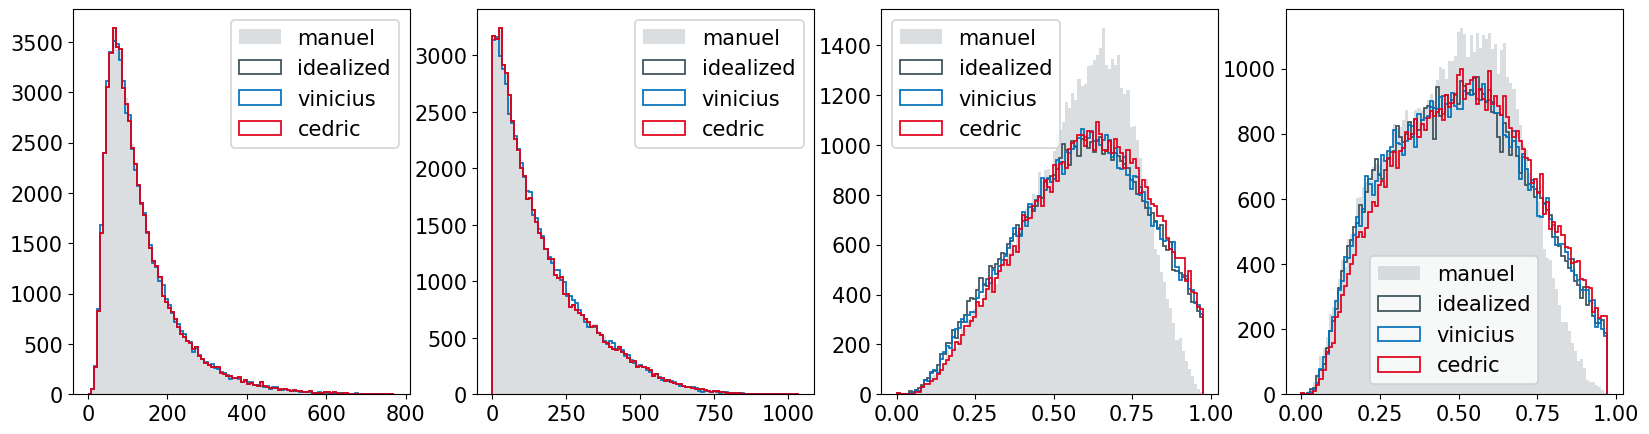

In [50]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axs.flatten()):
    hist = ax.hist(data_manuel[:, i], bins=100, alpha=0.5, label="manuel")
    ax.hist(cathode_data_id_plot[:, i], bins=hist[1], label="idealized", histtype="step")
    ax.hist(cathode_data_v_plot[:, i], bins=hist[1], label="vinicius", histtype="step")
    ax.hist(cathode_data_c_plot[:, i], bins=hist[1], label="cedric", histtype="step")
    ax.legend()
plt.show()

## save data

In [51]:
path_cathode_id = "/beegfs/desy/user/ewencedr/data/lhco/high_level/cathode_id.h5"
with h5py.File(path_cathode_id, "w") as f:
    f.create_dataset("data", data=cathode_data_id)

In [52]:
path_cathode_v = "/beegfs/desy/user/ewencedr/data/lhco/high_level/cathode_v.h5"
with h5py.File(path_cathode_v, "w") as f:
    f.create_dataset("data", data=cathode_data_v)


In [53]:
path_cathode_c = "/beegfs/desy/user/ewencedr/data/lhco/high_level/cathode_c.h5"
with h5py.File(path_cathode_c, "w") as f:
    f.create_dataset("data", data=cathode_data_c)